# How to Train Your Model (Live Demo #1)

![M-stack ecosystem](../figures/m_stack_ecosystem.png)

## 1. Import M-stack packages

In [88]:
%load_ext autoreload
%autoreload 2

# Useful standard and scientific ML libraries
import os
import time
import ase.io
import matplotlib.pyplot as plt
import numpy as np
import pyscf
import py3Dmol
import torch

# M-Stack packages
import equistore   # storage format for atomistic ML
import chemiscope  # interactive molecular visualization
import rascaline   # generating structural representations
import qstack      # quantum chemistry toolkit

from equistore import Labels, TensorBlock, TensorMap
from rascaline.utils import clebsch_gordan, rotations

# Torch-based density leaning
from rholearn import io, data, features, loss, models, plots, training, utils
from settings import RASCAL_HYPERS, DATA_SETTINGS, ML_SETTINGS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Visualize and explore dataset: `chemiscope`

* `chemiscope` is an interactive structure and property viewer

In [3]:
# Read the water molecules from file
frames = ase.io.read(os.path.join(DATA_SETTINGS["data_dir"], "water_monomers_1k.xyz"), index=":")
structure_idxs = np.arange(len(frames))
# structure_idxs

# Display molecules with chemiscope
# chemiscope.show(
#     frames,
#     properties={
#         "Mean O-H bond length, Angstrom": [np.mean([f.get_distance(0, 1), f.get_distance(0, 2)]) for f in frames],
#         "H-O-H angle, degrees": [f.get_angle(1, 0, 2) for f in frames],
#     },
# )

# 3. Generate $\lambda$-SOAP descriptors

### Calculate

In [90]:
lambdas = np.array([0, 1, 2, 3, 4, 5])

n_frames = 1000

# Generate lambda-SOAP
lsoap = clebsch_gordan.lambda_soap_vector(
    frames[:n_frames],
    rascal_hypers=RASCAL_HYPERS,
    lambdas=lambdas,
    only_keep_parity=+1,
)

### Check the equivariance condition

In [94]:
# Check equivariance

# Generate Wigner-D matrices, initialized with random angles
wig = rotations.WignerDReal(lmax=RASCAL_HYPERS["max_angular"])
print("Random rotation angles (rad):", wig.angles)

# Apply an O(3) transformation to each frame 
frames_o3 = [rotations.transform_frame_o3(frame, wig.angles) for frame in frames]
assert not np.allclose(frames[0].positions, frames_o3[0].positions)

# Generate lambda-SOAP for the transformed frames
lsoap_o3 = clebsch_gordan.lambda_soap_vector(
    frames_o3,
    rascal_hypers=RASCAL_HYPERS,
    lambdas=lambdas,
    only_keep_parity=+1,
)

# Apply the O(3) transformation to the TensorMap
lsoap_transformed = wig.transform_tensormap_o3(lsoap)

# Check for equivariance!
assert equistore.equal_metadata(lsoap_transformed, lsoap_o3)
assert equistore.allclose(lsoap_transformed, lsoap_o3)
print("O(3) EQUIVARIANT!")

Random rotation angles (rad): [0.47061484 2.42610414 0.40160064]
O(3) EQUIVARIANT!


### Save

In [80]:
# Create a dir for lambda-SOAP
lsoap_dir = os.path.join(DATA_SETTINGS["data_dir"], "lsoap_new")
if not os.path.exists(lsoap_dir):
    os.mkdir(path=lsoap_dir)

# Split into separate TensorMaps for each structure
lsoap_split = equistore.split(
    lsoap,
    axis="samples",
    grouped_labels=[
        Labels(names="structure", values=np.array([A]).reshape(-1, 1))
        for A in range(n_frames)
    ],
)

# Save the lambda-SOAP features for each structure to a separate dir
for A, frame in enumerate(frames[:n_frames]):
    # Create dir
    struct_dir = os.path.join(lsoap_dir, f"{A}")
    if not os.path.exists(struct_dir):
        os.mkdir(path=struct_dir)
    # Save
    equistore.save(os.path.join(struct_dir, "x.npz"), lsoap_split[A])

# 4. Build the torch dataset and dataloader

In [95]:
# Get the grouped indices for train/test(/val) splits
train_idxs, test_idxs, val_idxs = data.group_idxs(
    structure_idxs,
    n_groups=DATA_SETTINGS["n_groups"],
    group_sizes=DATA_SETTINGS["group_sizes"],
    shuffle=DATA_SETTINGS["shuffle"],
    seed=DATA_SETTINGS["seed"],
)

# Define new dir for storing standardized features
rho_std_dir = os.path.join(DATA_SETTINGS["data_dir"], "rho_std")
if not os.path.exists(rho_std_dir):
    os.mkdir(rho_std_dir)

np.savez(
    os.path.join(DATA_SETTINGS["data_dir"], "rho", "grouped_idxs.npz"),
    train_idxs=train_idxs,
    test_idxs=test_idxs,
    val_idxs=val_idxs,
)
np.savez(
    os.path.join(rho_std_dir, "grouped_idxs.npz"),
    train_idxs=train_idxs,
    test_idxs=test_idxs,
    val_idxs=val_idxs,
)

# Load the training set and join into a single TensorMap
c_list = [
    equistore.load(os.path.join(DATA_SETTINGS["data_dir"], "rho", f"{i}", "c.npz"))
    for i in train_idxs
]
c_train = equistore.join(c_list, axis="samples")

# Get the invariant means
inv_means = features.get_invariant_means(c_train)
equistore.save(os.path.join(DATA_SETTINGS["data_dir"], "rho", "inv_means.npz"), inv_means)
equistore.save(os.path.join(rho_std_dir, "inv_means.npz"), inv_means)

# Standardize the invariants
for A in range(1000):
    c = equistore.load(os.path.join(DATA_SETTINGS["data_dir"], "rho", f"{A}", "c.npz"))
    c_std = features.standardize_invariants(c, inv_means)
    c_dir = os.path.join(rho_std_dir, f"{A}")
    if not os.path.exists(c_dir):
        os.mkdir(c_dir)
    equistore.save(os.path.join(c_dir, "c.npz"), c_std)

In [129]:
# Build density dataset
rho_data = data.RhoData(
    structure_idxs,
    input_dir=os.path.join(DATA_SETTINGS["data_dir"], "lsoap_new"),
    output_dir=os.path.join(DATA_SETTINGS["data_dir"], "rho_std"),
    overlap_dir=os.path.join(DATA_SETTINGS["data_dir"], "rho"),
    **ML_SETTINGS["torch"],
)

# Build the train and test dataloaders
train_loader = data.RhoLoader(
    rho_data, subset_idxs=train_idxs, **ML_SETTINGS["loading"]
)
test_loader = data.RhoLoader(rho_data, subset_idxs=test_idxs, **ML_SETTINGS["loading"])

# Load a dummy batch for initializing the model
a_list, x_list, c_list, s_list = next(iter(train_loader))

# Define the keys as the intersection of those for the input and output
keys = x_list[0].keys.intersection(c_list[0].keys)

# Initialize model
model = models.RhoModel(
    model_type=ML_SETTINGS["model"]["type"],
    keys=keys,
    in_features=[x_list[0][key].properties for key in keys],
    out_features=[c_list[0][key].properties for key in keys],
    components=[x_list[0][key].components for key in keys],
    **ML_SETTINGS["model"]["args"],
)

# Initialize optimizer and scheduler
optimizer = ML_SETTINGS["optimizer"]["algorithm"](
    params=model.parameters(),
    **ML_SETTINGS["optimizer"]["args"],
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=optimizer,
    milestones=np.array([3, 6]),
    gamma=0.1,
)

# Initialize loss function
rho_loss_fn = loss.RhoLoss()
coeff_loss_fn = loss.CoeffLoss()

# 5. Run training

In [139]:
io.log("log.txt", "# Model training")
io.log("log.txt", "# epoch train_loss test_loss lr time learning_on")

train_losses = []
test_losses = []
for epoch in range(ML_SETTINGS["training"]["n_epochs"]):

    t0 = time.time()

    # Set some epoch-dependent settings
    check_args = True if epoch == 0 else False
    use_rho_loss = True if epoch > 5 else False

    # Iterate over training batches
    for train_batch in train_loader:

        # Reset gradients
        optimizer.zero_grad()

        # Make a prediction and evaluate loss for each train structure in the batch
        train_loss = 0
        for a_train, x_train, c_train, s_train in zip(*train_batch):

            # Make a prediction
            c_train_pred = model(x_train, check_args=check_args)

            # Evaluate the loss with either CoeffLoss or RhoLoss
            if use_rho_loss:
                train_loss += rho_loss_fn(c_train_pred, c_train, s_train, check_args=check_args)
            else:  # use CoeffLoss
                train_loss += coeff_loss_fn(c_train_pred, c_train, check_args=check_args)

        # Calculate gradient and update parameters
        train_loss.backward(retain_graph=True)
        optimizer.step()

        # Store training loss
        train_losses.append(train_loss.detach().numpy())

    # Iterate over test batches
    for test_batch in test_loader:

        # Make a prediction and evaluate loss for each test structure in the batch
        test_loss = 0
        for a_test, x_test, c_test, s_test in zip(*test_batch):

            # Make a prediction and evaluate the los *on the density*
            with torch.no_grad():
                c_test_pred = model(x_test, check_args=check_args)
                test_loss += rho_loss_fn(c_test_pred, c_test, s_test, check_args=check_args)

        test_losses.append(test_loss.detach().numpy())

    # Write log for the epoch
    io.log(
        "log.txt",
        f"{epoch} "
        f"{np.round(train_losses[-1], 5)} "
        f"{np.round(test_losses[-1], 5)} "
        f"{np.round(scheduler.get_last_lr()[0], 3)} "
        f"{np.round(time.time() - t0, 3)} "
        f"{'rho' if use_rho_loss else 'coeff'} "
    )
    scheduler.step()

# 6. Plot results

Text(0, 0.5, 'loss per batch')

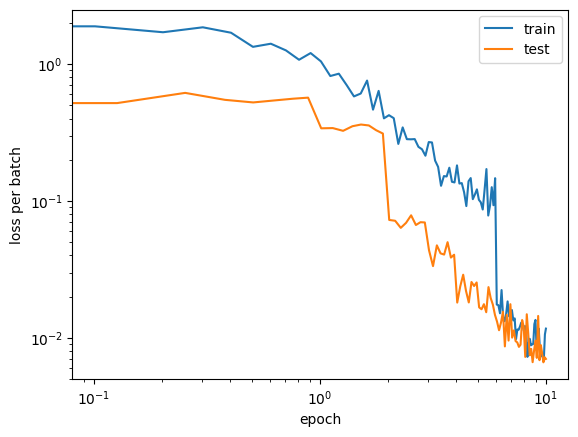

In [133]:
# Define the points on the x-axis - these are different for train and test as
# the number of batches per epoch is different
x_epoch_train = ML_SETTINGS["training"]["n_epochs"] * np.linspace(0, 1, len(train_losses))
x_epoch_test = ML_SETTINGS["training"]["n_epochs"] * np.linspace(0, 1, len(test_losses))

# Plot train and test loss versus epoch
fig, ax = plt.subplots()
ax.loglog(x_epoch_train, np.array(train_losses) / ML_SETTINGS["loading"]["batch_size"], label="train")
ax.loglog(x_epoch_test, np.array(test_losses) / ML_SETTINGS["loading"]["batch_size"], label="test")
ax.legend()
ax.set_xlabel("epoch")
ax.set_ylabel("loss per batch")

In [134]:
# Load the train and test losses
losses = np.load(os.path.join(ML_SETTINGS["run_dir"], "losses.npz"))

# Plot losses
fig, ax = plt.subplots(1, 1, sharey=True)
ax.loglog(
    losses["train"] / 500, 
    label="linear, train", 
    color="blue",
)
ax.loglog(
    losses["test"] / 300, 
    label="linear, test", 
    color="blue",
    linestyle="dashed"
)
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss per structure")
ax.set_ylim(1e-5, 1e-2)
ax.legend()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/joe.abbott/Documents/phd/code/rho/rho_learn/docs/example/water/runs/demo_linear/losses.npz'

## 7. Make a prediction on the validation structure

In [ ]:
# Load the input and output validation TensorMaps
in_val = io.load_tensormap_to_torch(
    os.path.join(DATA_SETTINGS["data_dir"], "in_val.npz"), **ML_SETTINGS["torch"]
)
out_val = equistore.load(os.path.join(DATA_SETTINGS["data_dir"], "out_val.npz"))

# Retrieve the unique structure
val_idx = equistore.unique_metadata(in_val, axis="samples", names="structure")[0][0]
val_frame = ase.io.read(
    os.path.join(DATA_SETTINGS["data_dir"], "water_monomers_1k.xyz"), index=val_idx
)

# Build a pyscf Molecule object
val_mol = pyscf.gto.Mole().build(
    atom=[
        (i, j) for i, j in zip(val_frame.get_chemical_symbols(), val_frame.positions)
    ],
    basis="ccpvqz jkfit",
)

# Predict the density
out_val_pred, coeffs = predictor.predict_density_from_mol(
    in_val,
    val_mol,
    model_path=os.path.join(ML_SETTINGS["run_dir"], "epoch_10", "model.pt"),
    inv_means_path=os.path.join(DATA_SETTINGS["data_dir"], "inv_means.npz"),
)

### Parity plot: target vs predicted coefficients

In [ ]:
# Calculate the MSE Error
with torch.no_grad():
    val_loss = loss.MSELoss(reduction="sum")(
        utils.tensor_to_torch(out_val, **ML_SETTINGS["torch"]), 
        utils.tensor_to_torch(out_val_pred, **ML_SETTINGS["torch"])
    ).detach().numpy()

# Plot the target vs predicted coefficients, standardized
fig, ax = plots.parity_plot(
    target=out_val,
    predicted=out_val_pred,
    color_by="spherical_harmonics_l",
)
lim = [-0.05, 0.1]
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect("equal")
ax.set_xlabel("target density coefficient")
ax.set_ylabel("predicted density coefficient")
ax.set_title(f"Validation MSE Error: {round(val_loss * 1e6, 3)}"r" $\times 10^{-6}$")
ax.legend()

# 8. Process densities with `Q-stack` and visualize

In [ ]:
# Build a delta density TensorMap
out_val_delta = equistore.abs(equistore.subtract(out_val_pred, out_val))

# Vectorize the coefficients from each of the TensorMaps
new_key_names = ["spherical_harmonics_l", "element"]
vect_coeffs_target = qstack.equio.tensormap_to_vector(
    val_mol,
    utils.rename_tensor(
        utils.drop_metadata_name(out_val, "samples", "structure"),
        keys_names=new_key_names,
    ),
)
vect_coeffs_input = qstack.equio.tensormap_to_vector(
    val_mol,
    utils.rename_tensor(
        utils.drop_metadata_name(out_val_pred, "samples", "structure"),
        keys_names=new_key_names,
    ),
)
vect_coeffs_delta = qstack.equio.tensormap_to_vector(
    val_mol,
    utils.rename_tensor(
        utils.drop_metadata_name(out_val_delta, "samples", "structure"),
        keys_names=new_key_names,
    ),
)

# Convert the basis function coefficients to a cube file
plot_dir = os.path.join(ML_SETTINGS["run_dir"], "plots")
io.check_or_create_dir(plot_dir)
n = 60  # grid points per dimension
for (coeffs, filename) in [
    (vect_coeffs_target, "out_val.cube"),
    (vect_coeffs_input, "out_val_pred.cube"),
    (vect_coeffs_delta, "out_val_delta.cube"),
]:
    qstack.fields.density2file.coeffs_to_cube(
        val_mol,
        coeffs,
        os.path.join(plot_dir, filename),
        nx=n,
        ny=n,
        nz=n,
        resolution=None,
    )

### Predicted electron density

In [ ]:
# Visualize the predicted density
v = py3Dmol.view()
v.addModelsAsFrames(open(os.path.join(plot_dir, "out_val_pred.cube"), "r").read(), "cube")
v.setStyle({"stick": {}})
v.addVolumetricData(
    open(os.path.join(plot_dir, "out_val_pred.cube"), "r").read(),
    "cube",
    {"isoval": 0.05, "color": "blue", "opacity": 0.8},
)
v.show()

### "Delta electron density" - i.e. the ML error (100x magnification)

In [ ]:
# Visualize the delta density
v = py3Dmol.view()
v.addModelsAsFrames(open(os.path.join(plot_dir, "out_val_delta.cube"), "r").read(), "cube")
v.setStyle({"stick": {}})
v.addVolumetricData(
    open(os.path.join(plot_dir, "out_val_delta.cube"), "r").read(),
    "cube",
    {"isoval": 0.0005, "color": "blue", "opacity": 0.8},
)
v.show()

# Extra Material

* DIY session at poster #14

* Torch-based electron density learning at https://github.com/m-stack-org/rho_learn ...

* ... with examples/tutorials for:

    * water
    
    * azoswitch molecules
    
    
![azoswitch density](../figures/azoswitch_density.png)